In [10]:
# Lib
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial as sp
import pickle
from helpers import *
from GradientEstimation import *
from DisplacementFields import *

%load_ext autoreload
%autoreload 2

mm_to_inches = 0.1/2.54

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Times New Roman"
})
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "Times New Roman"

path = "Simulation_Data/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### TEST 1: Convergence Rate of Finite Difference Error

To control for measurement error, we set $\sigma = 0$.

(i) Fixed $m$, varying $R$

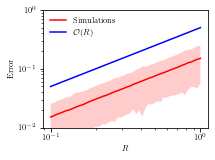

In [444]:
# simulation and plot
saveon = True

filename = "FD_sigma_fixed_m_fixed_R_varied"

R = np.exp(np.linspace(np.log(0.1),np.log(1.))) #### VARYING RADIUS

m = 7
sigma = 0.

Ntests = 10000

u_field = Sinusoid()

frob_err = np.zeros([len(R)])
frob_err_theory = np.zeros([len(R)])

frob_std = np.zeros([len(R)])

error_sample = np.zeros([Ntests])

for i,R_i in enumerate(R):
    for j in range(Ntests):
        
        r = np.zeros([m+1,])
        t = np.zeros([m+1,])
        p = np.zeros([m+1,])
        r[1:] = R_i*np.power(np.random.uniform(0,1,size=[m,]),1./3.)
        t[1:] = 2.*np.pi*np.random.uniform(0,1,size=[m,])
        p[1:] = np.pi*np.random.uniform(0,1,size=[m,])
        X = np.vstack([r*np.cos(t)*np.sin(p),r*np.sin(t)*np.sin(p),r*np.cos(p)]).T # Uniformly random particle field
        
        u_field.random() # Random sinusoidal displacement field, frequency stays the same
        U = u_field(X)
        
        m_neighbors = np.arange(1,m+1)
        #grad_u = EstimateGradient2(0,m_neighbors,X,U,method='deterministic')
        grad_u = EstimateGradient(0,m_neighbors,X,U)
        
        grad_u_exact = u_field.grad(np.zeros([3]))
        
        err = np.linalg.norm(grad_u-grad_u_exact)/np.linalg.norm(grad_u_exact+np.eye(3))
        frob_err[i] += err/Ntests
        
        error_sample[j] = np.copy(err)
        
        #### ASIDE ON FD ERROR COMPUTATION
        A = 1/(R_i**2*m)*X.T@X
        frob_err_theory[i] += R_i/np.sqrt(2*m)*np.sqrt(np.sum(np.sum(np.linalg.solve(A,X.T)**2,axis=0)*np.sum(X**2,axis=1)**2))/R_i**3/Ntests
        ####
        
    frob_std[i] = np.sqrt(1/(Ntests-1)*np.sum((error_sample-frob_err[i])**2) )
        
fig,ax = plt.subplots(figsize=(75*mm_to_inches,55*mm_to_inches))

ax.set_xlabel(r'$R$',fontsize=8)
ax.set_ylabel(r'Error',fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.loglog(R,frob_err,'r',R,0.5*R,'b')

ax.fill_between(R, frob_err-frob_std, frob_err+frob_std,facecolor='red',alpha=0.2)

ax.set(ylim=((10**(-2),10**0)))

ax.legend([r'Simulations','$\mathcal{O}(R)$'],fontsize=8,frameon=False)

if saveon and Ntests==10000:
    fig.savefig(path+filename+'.png',dpi=300,bbox_inches='tight')
    
    file = open(path+filename+'_data.pickle', 'wb')
    pickle.dump([sigma,m,R,frob_err,frob_std], file)
    file.close()

In [11]:
# read simulation and plot
filename = "FD_sigma_fixed_m_fixed_R_varied"

with open(path+filename+'_data.pickle', "rb") as input_file:
    [sigma,m,R,frob_err,frob_std] = pickle.load(input_file)

fig,ax = plt.subplots(figsize=(75*mm_to_inches,55*mm_to_inches))

ax.set_xlabel(r'$R$',fontsize=8)
ax.set_ylabel(r'Error',fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.loglog(R,frob_err,'r',R,0.5*R,'b')

ax.fill_between(R, frob_err-frob_std, frob_err+frob_std,facecolor='red',alpha=0.2)

ax.set(ylim=((10**(-2),10**0)))

ax.legend([r'Simulations','$\mathcal{O}(R)$'],fontsize=8,frameon=False)

fig.savefig(path+filename+'.png',dpi=300,bbox_inches='tight')

(ii) Fixed $R$, varying $m$

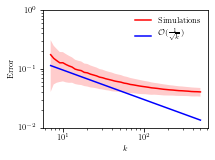

In [445]:
# simulation and plot
saveon = True

filename = "FD_sigma_fixed_m_varied_R_fixed"

m = np.exp(np.linspace(np.log(7),np.log(500))) #### VARYING NUMBER OF NEIGHBORS

sigma = 0.
Ntests = 10000
R = 1.

u_field = Sinusoid()

frob_err = np.zeros([len(m)])
frob_err_theory = np.zeros([len(m)])

frob_std = np.zeros([len(m)])

error_sample = np.zeros([Ntests])

for i,m_i in enumerate(m):
    n = int(m_i)
    for j in range(Ntests):
        
        r = np.zeros([n+1,])
        t = np.zeros([n+1,])
        p = np.zeros([n+1,])
        r[1:] = R*np.power(np.random.uniform(0,1,size=[n,]),1./3.)
        t[1:] = 2.*np.pi*np.random.uniform(0,1,size=[n,])
        p[1:] = np.pi*np.random.uniform(0,1,size=[n,])
        X = np.vstack([r*np.cos(t)*np.sin(p),r*np.sin(t)*np.sin(p),r*np.cos(p)]).T # Uniformly random particle field
        
        u_field.random() # Random sinusoidal displacement field, frequency stays the same
        U = u_field(X)
                
        m_neighbors = np.arange(1,n+1)
        grad_u = EstimateGradient(0,m_neighbors,X,U)
        
        grad_u_exact = u_field.grad(np.zeros([3]))
        
        err = np.linalg.norm(grad_u-grad_u_exact)/np.linalg.norm(grad_u_exact+np.eye(3))
        frob_err[i] += err/Ntests
                
        error_sample[j] = np.copy(err)
        
        #### ASIDE ON FD ERROR COMPUTATION
        A = 1/(R**2*n)*X.T@X
        frob_err_theory[i] += R/(np.sqrt(2*n))*np.sqrt(np.sum(np.sum(np.linalg.solve(A,X.T)**2,axis=0)*np.sum(X**2,axis=1)**2))/R**3/Ntests
        ####
    
    frob_std[i] = np.sqrt(1/(Ntests-1)*np.sum((error_sample-frob_err[i])**2) )
        
fig,ax = plt.subplots(figsize=(75*mm_to_inches,55*mm_to_inches))

ax.set_xlabel(r'$k$',fontsize=8)
ax.set_ylabel('Error',fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.loglog(m,frob_err,'r',m,0.3/np.sqrt(m),'b')
ax.fill_between(m, frob_err-frob_std, frob_err+frob_std,facecolor='red',alpha=0.2)

ax.legend(['Simulations',r'$\mathcal{O}(\frac{1}{\sqrt{k}})$'],fontsize=8,frameon=False)
ax.set(ylim=((10**(-2),10**0)))

if saveon and Ntests==10000:
    fig.savefig(path+filename+'.png',dpi=300,bbox_inches='tight')
    
    file = open(path+filename+'_data.pickle', 'wb')
    pickle.dump([sigma,m,R,frob_err,frob_std], file)
    file.close()

#ax.set_title('$R=1$, $\sigma=0$')
#fig.savefig(path+"FD_sigma_fixed_m_varied_R_fixed_order2.png",bbox_inches='tight')

In [12]:
# read simulation and plot
filename = "FD_sigma_fixed_m_varied_R_fixed"

with open(path+filename+'_data.pickle', "rb") as input_file:
    [sigma,m,R,frob_err,frob_std] = pickle.load(input_file)

fig,ax = plt.subplots(figsize=(75*mm_to_inches,55*mm_to_inches))

ax.set_xlabel(r'$k$',fontsize=8)
ax.set_ylabel('Error',fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.loglog(m,frob_err,'r',m,0.5/np.sqrt(m),'b')
ax.fill_between(m, frob_err-frob_std, frob_err+frob_std,facecolor='red',alpha=0.2)

ax.set(ylim=((10**(-2),10**0)))

ax.legend(['Simulations',r'$\mathcal{O}(\frac{1}{\sqrt{k}})$'],fontsize=8,frameon=False,loc='upper left')

fig.savefig(path+filename+'.png',dpi=300,bbox_inches='tight')


### TEST 2: Convergence Rate of Measurement Error

(i) We begin by assessing the impact of noise on the error. We fix $R$ and $m$.

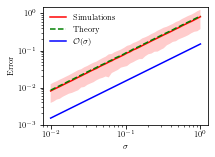

In [14]:
# simulation and plot
saveon = True

filename = "MSMT_sigma_varied_m_fixed_R_fixed"

sigma = np.exp(np.linspace(np.log(0.01),np.log(1.))) #### VARYING NOISE

Ntests = 10000
m = 7
R = 1.

u_field = LinearDisplacement()

frob_err_noisy = np.zeros([len(sigma)])

###
frob_err_theory = np.zeros([len(sigma)])
###

frob_std = np.zeros([len(sigma)])

error_sample = np.zeros([Ntests])

for i,s_i in enumerate(sigma):
    for j in range(Ntests):
        
        r = np.zeros([m+1,])
        t = np.zeros([m+1,])
        p = np.zeros([m+1,])
        r[1:] = R*np.power(np.random.uniform(0,1,size=[m,]),1./3.)
        t[1:] = 2.*np.pi*np.random.uniform(0,1,size=[m,])
        p[1:] = np.pi*np.random.uniform(0,1,size=[m,])
        X = np.vstack([r*np.cos(t)*np.sin(p),r*np.sin(t)*np.sin(p),r*np.cos(p)]).T # Uniformly random particle field
        
        #noise = np.random.normal(scale=s_i,size=[m+1,3]) # gaussian noise
        noise = np.random.normal(scale=s_i/np.sqrt(3),size=[m+1,3]) # gaussian noise
        
        u_field.random() # Random sinusoidal displacement field, frequency stays the same
        U_noisy = u_field(X) + noise 
        
        m_neighbors = np.arange(1,m+1)
        grad_u_noisy = EstimateGradient(0,m_neighbors,X,U_noisy)
        
        grad_u_exact = u_field.grad(np.zeros([3]))
        
        err_noisy = np.linalg.norm(grad_u_noisy-grad_u_exact,ord='fro')/np.linalg.norm(grad_u_exact+np.eye(3))
        
        frob_err_noisy[i] += err_noisy/Ntests
        
        error_sample[j] = np.copy(err_noisy)
        
        #### ASIDE ON MEASUREMENT ERROR COMPUTATION
        A = 1/(R**2*m)*X.T@X
        frob_err_theory[i] += (s_i/(R*m)*np.sqrt( np.linalg.norm(np.linalg.solve(A,np.sum(X,axis=0)/R))**2 + m*np.trace(np.linalg.inv(A)) ))/ np.linalg.norm(grad_u_exact+np.eye(3)) /Ntests
        ####
        
    frob_std[i] = np.sqrt(1/(Ntests-1)*np.sum((error_sample-frob_err_noisy[i])**2) )

fig,ax = plt.subplots(figsize=(75*mm_to_inches,55*mm_to_inches))

ax.set_xlabel(r'$\sigma$',fontsize=8)
ax.set_ylabel('Error',fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.loglog(sigma,frob_err_noisy,'r',sigma,frob_err_theory,'g--', sigma,0.15*sigma,'b')

ax.fill_between(sigma, frob_err_noisy-frob_std, frob_err_noisy+frob_std,facecolor='red',alpha=0.2)

ax.set(ylim=((10**(-3),1.5*10**0)))

ax.legend(['Simulations','Theory',r'$\mathcal{O}(\sigma)$'],fontsize=8,frameon=False)

if saveon and Ntests==10000:
    fig.savefig(path+filename+'.png',dpi=300,bbox_inches='tight')
    file = open(path+filename+'_data.pickle', 'wb')
    pickle.dump([sigma,m,R,frob_err_noisy,frob_std,frob_err_theory], file)
    file.close()

#ax.set_title('$R=1$, $k=15$')
#fig.savefig(path+"MSMT_sigma_varied_m_fixed_R_fixed_order2.png",bbox_inches='tight')

In [13]:
# read simulation and plot
filename = "MSMT_sigma_varied_m_fixed_R_fixed"

with open(path+filename+'_data.pickle', "rb") as input_file:
    [sigma,m,R,frob_err_noisy,frob_std,frob_err_theory] = pickle.load(input_file)

fig,ax = plt.subplots(figsize=(75*mm_to_inches,55*mm_to_inches))

ax.set_xlabel(r'$\sigma$',fontsize=8)
ax.set_ylabel('Error',fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.loglog(sigma,frob_err_noisy,'r',sigma,frob_err_theory,'g--', sigma,0.15*sigma,'b')

ax.fill_between(sigma, frob_err_noisy-frob_std, frob_err_noisy+frob_std,facecolor='red',alpha=0.2)

ax.set(ylim=((10**(-3),1.5*10**0)))

ax.legend(['Simulations','Theory',r'$\mathcal{O}(\sigma)$'],fontsize=8,frameon=False)

fig.savefig(path+filename+'.png',dpi=300,bbox_inches='tight')

(ii) Assess the impact of $m$ on the measurement error by fixing $R$ and $\sigma$, and taking a first-order polynomial displacement field, such that the $U$ has zero curvature.

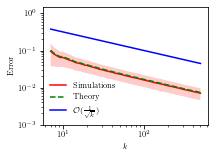

In [16]:
# simulation and plot
saveon = True

filename = "MSMT_sigma_fixed_m_varied_R_fixed"

m = np.exp(np.linspace(np.log(7),np.log(500))) #### VARYING NUMBER OF NEIGHBORS

sigma = 0.1
Ntests = 10000
R = 1.

u_field = LinearDisplacement()

frob_err_noisy = np.zeros([len(m)])

frob_err_theory = np.zeros([len(m)])

frob_std = np.zeros([len(m)])

error_sample = np.zeros([Ntests])

for i,m_i in enumerate(m):
    n = int(m_i)
    for j in range(Ntests):
        
        r = np.zeros([n+1,])
        t = np.zeros([n+1,])
        p = np.zeros([n+1,])
        r[1:] = R*np.power(np.random.uniform(0,1,size=[n,]),1./3.)
        t[1:] = 2.*np.pi*np.random.uniform(0,1,size=[n,])
        p[1:] = np.pi*np.random.uniform(0,1,size=[n,])
        X = np.vstack([r*np.cos(t)*np.sin(p),r*np.sin(t)*np.sin(p),r*np.cos(p)]).T # Uniformly random particle field
        noise = np.random.normal(scale=sigma/np.sqrt(3),size=[n+1,3]) # gaussian noise
        
        u_field.random()
        U_noisy = u_field(X) + noise 
        
        m_neighbors = np.arange(1,n+1)
        grad_u_noisy = EstimateGradient(0,m_neighbors,X,U_noisy)
        
        grad_u_exact = u_field.grad(np.zeros([3]))
        
        err_noisy = np.linalg.norm(grad_u_noisy-grad_u_exact)/np.linalg.norm(grad_u_exact+np.eye(3))
        
        frob_err_noisy[i] += err_noisy/Ntests
        
        error_sample[j] = np.copy(err_noisy)
        
        #### ASIDE ON MEASUREMENT ERROR COMPUTATION
        A = 1/(R**2*n)*X.T@X
        frob_err_theory[i] += (sigma/(R*n)*np.sqrt( np.linalg.norm(np.linalg.solve(A,np.sum(X,axis=0)/R))**2 + n*np.trace(np.linalg.inv(A)) ))/np.linalg.norm(grad_u_exact+np.eye(3))/Ntests
        ####
        
    frob_std[i] = np.sqrt(1/(Ntests-1)*np.sum((error_sample-frob_err_noisy[i])**2) )
        
fig,ax = plt.subplots(figsize=(75*mm_to_inches,55*mm_to_inches))

ax.set_xlabel(r'$k$',fontsize=8)
ax.set_ylabel('Error',fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.loglog(m,frob_err_noisy,'r',m,frob_err_theory,'g--',m,1/np.sqrt(m),'b')
ax.fill_between(m, frob_err_noisy-frob_std, frob_err_noisy+frob_std,facecolor='red',alpha=0.2)

ax.set(ylim=((10**(-3),1.5*10**0)))

ax.legend(['Simulations','Theory',r'$\mathcal{O}(\frac{1}{\sqrt{k}})$'],fontsize=8,frameon=False)

if saveon and Ntests==10000:
    fig.savefig(path+filename+'.png',dpi=300,bbox_inches='tight')
    file = open(path+filename+'_data.pickle', 'wb')
    pickle.dump([sigma,m,R,frob_err_noisy,frob_std,frob_err_theory], file)
    file.close()
    
#ax.set_title('$R=1$, $\sigma=0.1$')
#fig.savefig(path+"MSMT_sigma_fixed_m_varied_R_fixed_order2.png",bbox_inches='tight')

In [14]:
# read simulation and plot
filename = "MSMT_sigma_fixed_m_varied_R_fixed"

with open(path+filename+'_data.pickle', "rb") as input_file:
    [sigma,m,R,frob_err_noisy,frob_std,frob_err_theory] = pickle.load(input_file)

fig,ax = plt.subplots(figsize=(75*mm_to_inches,55*mm_to_inches))

ax.set_xlabel(r'$k$',fontsize=8)
ax.set_ylabel('Error',fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.loglog(m,frob_err_noisy,'r',m,frob_err_theory,'g--',m,1/np.sqrt(m),'b')
ax.fill_between(m, frob_err_noisy-frob_std, frob_err_noisy+frob_std,facecolor='red',alpha=0.2)

ax.set(ylim=((10**(-3),1.5*10**0)))

ax.legend(['Simulations','Theory',r'$\mathcal{O}(\frac{1}{\sqrt{k}})$'],fontsize=8,frameon=False)

fig.savefig(path+filename+'.png',dpi=300,bbox_inches='tight')

(iii) Assess the impact of $R$ on the measurement error by fixing $m$ and $\sigma$, and taking a first-order polynomial displacement field, such that the $U$ has zero curvature.

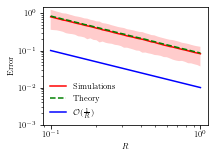

In [18]:
# simulation and plot
saveon = True

filename = "MSMT_sigma_fixed_m_fixed_R_varied"

R = np.exp(np.linspace(np.log(0.1),np.log(1))) #### VARYING RADIUS

m = 7
sigma = 0.1

Ntests = 10000

u_field = LinearDisplacement()

frob_err_noisy = np.zeros([len(R)])
frob_err_theory = np.zeros([len(R)])

frob_std = np.zeros([len(R)])

error_sample = np.zeros([Ntests])

for i,R_i in enumerate(R):
    for j in range(Ntests):
        
        r = np.zeros([m+1,])
        t = np.zeros([m+1,])
        p = np.zeros([m+1,])
        r[1:] = R_i*np.power(np.random.uniform(0,1,size=[m,]),1./3.)
        t[1:] = 2.*np.pi*np.random.uniform(0,1,size=[m,])
        p[1:] = np.pi*np.random.uniform(0,1,size=[m,])
        X = np.vstack([r*np.cos(t)*np.sin(p),r*np.sin(t)*np.sin(p),r*np.cos(p)]).T # Uniformly random particle field
        
        noise = np.random.normal(scale=sigma/np.sqrt(3),size=[m+1,3]) # gaussian noise
        u_field.random()
        U_noisy = u_field(X) + noise 
        
        m_neighbors = np.arange(1,m+1)
        grad_u_noisy = EstimateGradient(0,m_neighbors,X,U_noisy)
        
        grad_u_exact = u_field.grad(np.zeros([3]))
        
        err_noisy = np.linalg.norm(grad_u_noisy-grad_u_exact)/np.linalg.norm(grad_u_exact+np.eye(3))
        
        frob_err_noisy[i] += err_noisy/Ntests
        
        error_sample[j] = np.copy(err_noisy)
        
        #### ASIDE ON MEASUREMENT ERROR COMPUTATION
        A = 1/(R_i**2*m)*X.T@X
        frob_err_theory[i] += (sigma/(R_i*m)*np.sqrt( np.linalg.norm(np.linalg.solve(A,np.sum(X,axis=0)/R_i))**2 + m*np.trace(np.linalg.inv(A)) ))/np.linalg.norm(grad_u_exact+np.eye(3))/Ntests
        ####
        
    frob_std[i] = np.sqrt(1/(Ntests-1)*np.sum((error_sample-frob_err_noisy[i])**2) )
        
fig,ax = plt.subplots(figsize=(75*mm_to_inches,55*mm_to_inches))

ax.set_xlabel(r'$R$',fontsize=8)
ax.set_ylabel('Error',fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.loglog(R,frob_err_noisy,'r',R,frob_err_theory,'g--',R,1e-2*1/R,'b')
ax.fill_between(R, frob_err_noisy-frob_std, frob_err_noisy+frob_std,facecolor='red',alpha=0.2)

ax.set(ylim=((10**(-3),1.5*10**0)))

ax.legend(['Simulations','Theory','$\mathcal{O}(\\frac{1}{R})$'],fontsize=8,frameon=False)

if saveon and Ntests==10000:
    fig.savefig(path+filename+'.png',dpi=300,bbox_inches='tight')
    file = open(path+filename+'_data.pickle', 'wb')
    pickle.dump([sigma,m,R,frob_err_noisy,frob_std,frob_err_theory], file)
    file.close()
    
#ax.set_title('$k=15$, $\sigma=0.1$')
#fig.savefig(path+"MSMT_sigma_fixed_m_fixed_R_varied_order2.png",bbox_inches='tight')

In [15]:
# read simulation and plot
filename = "MSMT_sigma_fixed_m_fixed_R_varied"

with open(path+filename+'_data.pickle', "rb") as input_file:
    [sigma,m,R,frob_err_noisy,frob_std,frob_err_theory] = pickle.load(input_file)

fig,ax = plt.subplots(figsize=(75*mm_to_inches,55*mm_to_inches))

ax.set_xlabel(r'$R$',fontsize=8)
ax.set_ylabel('Error',fontsize=8)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.loglog(R,frob_err_noisy,'r',R,frob_err_theory,'g--',R,1e-2*1/R,'b')
ax.fill_between(R, frob_err_noisy-frob_std, frob_err_noisy+frob_std,facecolor='red',alpha=0.2)

ax.set(ylim=((10**(-3),1.5*10**0)))

ax.legend(['Simulations','Theory','$\mathcal{O}(\\frac{1}{R})$'],fontsize=8,frameon=False)

fig.savefig(path+filename+'.png',dpi=300,bbox_inches='tight')